Implementation of linear binary classification models from scratch and their comparison. Extension to multiclass logistic regression using the softmax function, along with a comparison of softmax to other multiclass strategies such as One-vs-All

In [1]:
import numpy as np

In [2]:
import seaborn as sns
import pandas as pd

df = sns.load_dataset('penguins')



df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Binary classification – predicting whether the species of a penguin is "name of species" or not (1 or 0).
Multiclass classification – predicting the species of a penguin using softmax or by applying multiple binary classifiers.



In [3]:
print(df['sex'].unique())
print(df['species'].unique())
print(df['island'].unique())

['Male' 'Female' nan]
['Adelie' 'Chinstrap' 'Gentoo']
['Torgersen' 'Biscoe' 'Dream']


Let's drop Nans from sex

In [4]:
df.dropna(subset=['sex'], inplace=True)
print(df['sex'].unique())

['Male' 'Female']


In [5]:
df.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

By removing nans from sex we removed other missing values

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

numerical_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_features = ['island', 'sex']
classes_dict = {
    'Adelie': 0,
    'Chinstrap': 1, 
    'Gentoo': 2,
}
X = df.drop(columns=['species'])
y = df['species'].map(classes_dict)
print(y.unique())


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=42)
ss = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ss.fit(X_train[numerical_features])
ohe.fit(X_train[categorical_features])

[0 1 2]


OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [7]:
def preprocess_data(X):
    X_numerical = X[numerical_features]
    X_numerical = ss.transform(X_numerical)
    X_categorical = X[categorical_features]
    X_categorical = ohe.transform(X_categorical)
    return np.concatenate((X_numerical, X_categorical), axis=1)

In [8]:
X_train, X_test = preprocess_data(X_train), preprocess_data(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [9]:
y_0_train, y_0_test = (y_train == 0).astype('int'), (y_test == 0).astype('int')
y_1_train, y_1_test = (y_train == 1).astype('int'), (y_test == 1).astype('int')
y_2_train, y_2_test = (y_train == 2).astype('int'), (y_test == 2).astype('int')
y_0_train.shape

(266,)

In [10]:
class BinaryLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000, lambda_reg=1e-2):
        self.alpha = learning_rate
        self.epochs = epochs
        self.lambda_reg = lambda_reg / 2 #for convenience 
        self.w = None
        self.b = None
        
    def _cross_entropy(self, y, p):           
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p)) + self.lambda_reg * np.sum(self.w ** 2)
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
        
    def fit(self, X, y, border=0.0001):
        n_features = X.shape[1]
        self.w = np.random.randn(n_features)
        self.b = 0

        old_loss = float('inf')
        for epoch in range(self.epochs):
            p = self.predict_proba(X)

            loss = self._cross_entropy(y, p)
            if epoch % 100 == 0:
                print('Cross entropy:', loss)
            if abs(old_loss - loss) < border:
                break
            old_loss = loss
                  
            error = y - p
            grad = -X.T.dot(error)
            reg = self.lambda_reg * self.w # L2
            self.w -= self.alpha * (grad + reg)
            self.b -= self.alpha * np.sum(error)
        return self
    def predict_proba(self, X):
        z = X.dot(self.w) + self.b
        p = np.clip(self._sigmoid(z), 1e-10, 1 - 1e-10)
        return p
    
    def predict(self, X, threshold=0.5):
        p = self.predict_proba(X)
        return np.where(p > threshold, 1, 0)        

In [11]:
# test classificators on one class
from sklearn.metrics import f1_score, accuracy_score
blogreg = BinaryLogisticRegression()

blogreg.fit(X_train, y_0_train)
print('size of y_0 train', y_0_train.shape, 'test', y_0_test.shape)
print("f1 of logreg, predict adelie:", f1_score(blogreg.predict(X_test), y_0_test))
print('accuracy of logreg, predict adelie', accuracy_score(blogreg.predict(X_test), y_0_test))

print('\n')
blogreg.fit(X_train, y_1_train)
print('size of y_1 train', y_1_train.shape, 'test', y_1_test.shape)
print("f1 of logreg, predict chinstrap:", f1_score(blogreg.predict(X_test), y_1_test))
print('accuracy of logreg, predict chinstrap', accuracy_score(blogreg.predict(X_test), y_1_test))

print('\n')
blogreg.fit(X_train, y_2_train)
print('size of y_2 train', y_2_train.shape, 'test', y_2_test.shape)
print("f1 of logreg, predict gentoo:", f1_score(blogreg.predict(X_test), y_2_test))
print('accuracy of logreg, predict gentoo', accuracy_score(blogreg.predict(X_test), y_2_test))

# bsvm.fit(X_train, y_0_train)

Cross entropy: 217.42848681929758
Cross entropy: 5.687112063408204
Cross entropy: 3.97384561042776
Cross entropy: 3.3423527428912694
Cross entropy: 3.01935404714619
Cross entropy: 2.828287222923561
Cross entropy: 2.706079742437638
Cross entropy: 2.6244813144402532
Cross entropy: 2.5689259339617427
Cross entropy: 2.531137697370192
size of y_0 train (266,) test (67,)
f1 of logreg, predict adelie: 1.0
accuracy of logreg, predict adelie 1.0


Cross entropy: 314.7032493020353
Cross entropy: 2219.890638473168
Cross entropy: 3184.479421382969
Cross entropy: 3945.705229417273
Cross entropy: 4786.057261210821
Cross entropy: 5778.2691464471045
Cross entropy: 6950.414079523363
Cross entropy: 8318.988673850192
Cross entropy: 9887.429254072686
Cross entropy: 11663.547360652901
size of y_1 train (266,) test (67,)
f1 of logreg, predict chinstrap: 0.39436619718309857
accuracy of logreg, predict chinstrap 0.3582089552238806


Cross entropy: 685.4737020626519
Cross entropy: 9.112268162506211
Cross entro

Binary Log regressor clearly recognizes classes 0 and 2 but has big troubles with class 1
maybe deal is in learning_rate? (Bloom of gradients)

In [12]:
blogreg = BinaryLogisticRegression(learning_rate=0.000001)

blogreg.fit(X_train, y_1_train)
print('size of y_1 train', y_1_train.shape, 'test', y_1_test.shape)
print("f1 of logreg, predict chinstrap:", f1_score(blogreg.predict(X_test), y_1_test))
print('accuracy of logreg, predict chinstrap', accuracy_score(blogreg.predict(X_test), y_1_test))

Cross entropy: 126.51651332296979
Cross entropy: 126.44189697134425
Cross entropy: 126.36917737366221
Cross entropy: 126.29831596611905
Cross entropy: 126.22927507753165
Cross entropy: 126.16201791067378
Cross entropy: 126.0965085238647
Cross entropy: 126.032711812813
Cross entropy: 125.97059349272128
Cross entropy: 125.91012008065348
size of y_1 train (266,) test (67,)
f1 of logreg, predict chinstrap: 0.717948717948718
accuracy of logreg, predict chinstrap 0.835820895522388


not enough

Text(0.5, 1.0, 'test classes distr')

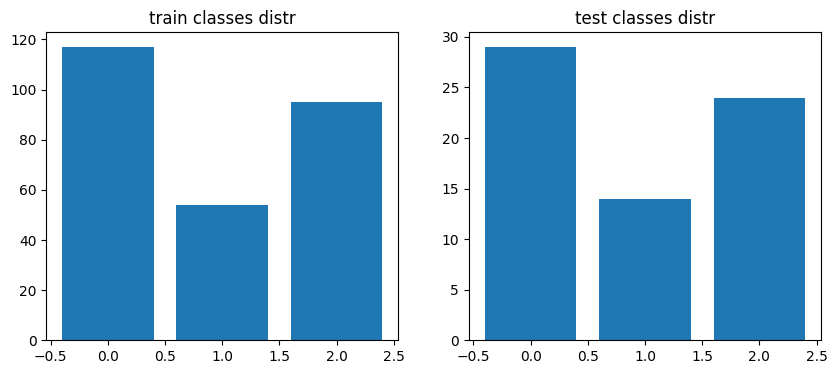

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
y_labels, y_unique_counts = np.unique(y_train, return_counts=True)
axs[0].bar(y_labels, y_unique_counts)
axs[0].set_title('train classes distr')

y_labels, y_unique_counts = np.unique(y_test, return_counts=True)
axs[1].bar(y_labels, y_unique_counts)
axs[1].set_title('test classes distr')

test and train are stratified - OK. But class "Chilstrap" is minor.
Problem is disbalance

In [14]:
from sklearn.utils import class_weight
y_0_weigths = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y = y_0_train,
)
print(y_0_weigths)

y_1_weigths = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y = y_1_train,
)
print(y_1_weigths)

y_2_weigths = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y = y_2_train,
)
print(y_2_weigths)

[0.89261745 1.13675214]
[0.62735849 2.46296296]
[0.77777778 1.4       ]


In [15]:
class BinaryLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000, lambda_reg=1e-2):
        self.alpha = learning_rate
        self.epochs = epochs
        self.lambda_reg = lambda_reg / 2 #for convenience 
        self.w = None
        self.class_weights = None
        self.b = None        
        
    def _cross_entropy(self, y, p):
        loss = y * np.log(p) + (1 - y) * np.log(1 - p)
        if self.class_weights is not None:
            sample_weights = np.array([self.class_weights[int(cl)] for cl in y])            
            # print(sample_weights)
            loss = loss * sample_weights
        return -np.sum(loss) + self.lambda_reg * np.sum(self.w ** 2)
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
        
    def fit(self, X, y, border=0.0001, class_weights=None):        
        n_features = X.shape[1]
        self.w = np.random.randn(n_features) * 0.01
        self.b = 0
        self.class_weights = class_weights

        old_loss = float('inf')
        for epoch in range(self.epochs):
            p = self.predict_proba(X)

            loss = self._cross_entropy(y, p)
            if epoch % 100 == 0:
                print('Cross entropy:', loss)
            if abs(old_loss - loss) < border:
                break
            old_loss = loss
                  
            error = y - p
            if self.class_weights is not None:
                sample_weights = np.array([self.class_weights[int(cl)] for cl in y])                
                error = error * sample_weights
            grad = -X.T.dot(error)
            reg = self.lambda_reg * self.w # L2
            self.w -= self.alpha * (grad + reg)
            self.b -= self.alpha * np.sum(error)
        return self
    def predict_proba(self, X):
        z = X.dot(self.w) + self.b
        p = np.clip(self._sigmoid(z), 1e-10, 1 - 1e-10)
        return p
    
    def predict(self, X, threshold=0.5):
        p = self.predict_proba(X)
        return np.where(p > threshold, 1, 0)        

In [16]:
# test classificators on one class
from sklearn.metrics import f1_score, accuracy_score
blogreg = BinaryLogisticRegression()

blogreg.fit(X_train, y_0_train) # it's ideal - don't touch
print('size of y_0 train', y_0_train.shape, 'test', y_0_test.shape)
print("f1 of logreg, predict adelie:", f1_score(blogreg.predict(X_test), y_0_test))
print('accuracy of logreg, predict adelie', accuracy_score(blogreg.predict(X_test), y_0_test))

print('\n')
blogreg.fit(X_train, y_2_train, class_weights=y_2_weigths)
print('size of y_2 train', y_2_train.shape, 'test', y_2_test.shape)
print("f1 of logreg, predict gentoo:", f1_score(blogreg.predict(X_test), y_2_test))
print('accuracy of logreg, predict gentoo', accuracy_score(blogreg.predict(X_test), y_2_test))


print('\n')
blogreg = BinaryLogisticRegression(learning_rate=0.0001)
blogreg.fit(X_train, y_1_train, class_weights=y_1_weigths)
print('size of y_1 train', y_1_train.shape, 'test', y_1_test.shape)
print("f1 of logreg, predict chinstrap:", f1_score(blogreg.predict(X_test), y_1_test))
print('accuracy of logreg, predict chinstrap', accuracy_score(blogreg.predict(X_test), y_1_test))


# bsvm.fit(X_train, y_0_train)

Cross entropy: 186.74308083104486
Cross entropy: 8.645818403510685
Cross entropy: 7.876001466652976
size of y_0 train (266,) test (67,)
f1 of logreg, predict adelie: 1.0
accuracy of logreg, predict adelie 1.0


Cross entropy: 190.1733084255526
Cross entropy: 5.024698802195819
size of y_2 train (266,) test (67,)
f1 of logreg, predict gentoo: 0.9795918367346939
accuracy of logreg, predict gentoo 0.9850746268656716


Cross entropy: 184.30878777142706
Cross entropy: 111.46792048299169
Cross entropy: 92.8706947436014
Cross entropy: 84.91565064568093
Cross entropy: 81.02048597314712
Cross entropy: 79.21842943407195
Cross entropy: 78.6902320898044
size of y_1 train (266,) test (67,)
f1 of logreg, predict chinstrap: 0.7368421052631579
accuracy of logreg, predict chinstrap 0.8507462686567164


It's better but also we can select optmial threshold (because results are medicore) by best f1_score

In [17]:
best_f1_score = 0
best_threshold = 0.5
blogreg = BinaryLogisticRegression(learning_rate=0.0001)
blogreg.fit(X_train, y_1_train, class_weights=y_1_weigths)
for i in range(10, 90, 5):
    thr = i / 100    
    f1 = f1_score(blogreg.predict(X_test, threshold=thr), y_1_test)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = thr    
print("f1", best_f1_score, "threshold", best_threshold)

Cross entropy: 183.64340573106384
Cross entropy: 111.36643085360538
Cross entropy: 92.77947003824387
Cross entropy: 84.78768608706876
Cross entropy: 80.8558357212344
Cross entropy: 79.02147725590595
Cross entropy: 78.46437016372218
f1 0.9333333333333333 threshold 0.7


Nice! It's acceptable. Too much False Positives - it was problem. 
Sure, in a real case, the threshold should be selected based on the validation set, not the test set.

In [19]:
class SVMBinaryClassificator:
    def __init__(self, learning_rate=0.01, epochs=1000, lambda_reg=1e-2):
        self.alpha = learning_rate
        self.epochs = epochs
        self.lambda_reg = lambda_reg / 2 #for convenience 
        self.w = None
        self.b = None

    def _hinge_loss(self, margin):        
        return np.sum(np.maximum(0, 1 - margin)) + self.lambda_reg * np.sum(self.w ** 2)
    
            

    def _calc_margin(self, X,y):        
        return y * (X.dot(self.w) + self.b) 
    
    def fit(self, X, y, border=0.0001):
        n_features = X.shape[1]
        self.w = np.random.randn(n_features)
        self.b = 0
        y_relabeled = y.copy()
        y_relabeled[y_relabeled == 0] = -1
        

        old_loss = float('inf')
        for epoch in range(self.epochs):            
            margin = self._calc_margin(X, y_relabeled)
            loss = self._hinge_loss(margin)
            if epoch % 100 == 0:
                print('Hinge loss:', loss)
            if abs(old_loss - loss) < border:
                break
            old_loss = loss            
            
            is_false = 1 > margin
            grad_base = np.where(is_false, -y_relabeled, 0)            

            self.w -= self.alpha * (X.T.dot(grad_base) + self.lambda_reg * self.w)
            self.b -= self.alpha * np.sum(grad_base)              
        return self 

    def predict_margin(self, X):
        return X.dot(self.w) + self.b
    def predict(self, X):
        y = np.sign(self.predict_margin(X))            
        y[y == -1] = 0
        return y                

In [20]:
# test classificators on one class
from sklearn.metrics import f1_score, accuracy_score
svm_classifier = SVMBinaryClassificator()

svm_classifier.fit(X_train, y_0_train)


print('size of y_0 train', y_0_train.shape, 'test', y_0_test.shape)
print("f1 of logreg, predict adelie:", f1_score(svm_classifier.predict(X_test), y_0_test))
print('accuracy of logreg, predict adelie', accuracy_score(svm_classifier.predict(X_test), y_0_test))

print('\n')
svm_classifier.fit(X_train, y_1_train)
print('size of y_1 train', y_1_train.shape, 'test', y_1_test.shape)
print("f1 of logreg, predict chinstrap:", f1_score(svm_classifier.predict(X_test), y_1_test))
print('accuracy of logreg, predict chinstrap', accuracy_score(svm_classifier.predict(X_test), y_1_test))

print('\n')
svm_classifier.fit(X_train, y_2_train)
print('size of y_2 train', y_2_train.shape, 'test', y_2_test.shape)
print("f1 of logreg, predict gentoo:", f1_score(svm_classifier.predict(X_test), y_2_test))
print('accuracy of logreg, predict gentoo', accuracy_score(svm_classifier.predict(X_test), y_2_test))

Hinge loss: 47.2401115482427
Hinge loss: 2.2829351130901343
Hinge loss: 1.7919300768400754
size of y_0 train (266,) test (67,)
f1 of logreg, predict adelie: 1.0
accuracy of logreg, predict adelie 1.0


Hinge loss: 344.20423444404105
Hinge loss: 2.8368301960065803
Hinge loss: 2.0358779485172906
Hinge loss: 1.716884427181188
Hinge loss: 1.56272573640023
size of y_1 train (266,) test (67,)
f1 of logreg, predict chinstrap: 0.9655172413793104
accuracy of logreg, predict chinstrap 0.9850746268656716


Hinge loss: 489.99038447701616
size of y_2 train (266,) test (67,)
f1 of logreg, predict gentoo: 1.0
accuracy of logreg, predict gentoo 1.0


Great! 
As we can see, the SVM handled class recognition without balancing, unlike logistic regression.

Important observation!
SVMs are inherently more robust to class imbalance due to their loss function (Hinge Loss), which ignores most correctly classified majority examples. They naturally focus on examples that are closest to the decision boundary (support vectors), which often include instances from the minority class.

Logistic regression, on the other hand, attempts to minimize the error across all examples. A large number of majority class samples can "outweigh" the influence of minority ones, leading to a shifted decision boundary and poor performance on the minority class unless additional measures are taken (such as class weighting or oversampling).

### let's realize multiclassification. One versus All for both models and softmax for logistic regression

In [21]:
classifier_0 = BinaryLogisticRegression()
classifier_1 = BinaryLogisticRegression(learning_rate=0.0001)
classifier_2 = BinaryLogisticRegression()

classifier_0.fit(X_train, y_0_train)
classifier_1.fit(X_train, y_1_train, class_weights=y_1_weigths)
classifier_2.fit(X_train, y_2_train, class_weights=y_2_weigths)

proba_0 = classifier_0.predict_proba(X_test)
proba_1 = classifier_1.predict_proba(X_test)
proba_2 = classifier_2.predict_proba(X_test)

y_pred = np.argmax(np.stack([proba_0, proba_1, proba_2], axis=1), axis=1)
print(np.unique(y_pred))
print(np.unique(y_test))

print('\nLogistic Regression One-Versus-All results')
print('f1:', f1_score(y_test, y_pred, average='macro'))
print('accuracy:', accuracy_score(y_test, y_pred))

Cross entropy: 183.04279679933958
Cross entropy: 8.538529141506253
Cross entropy: 7.7592061339100065
Cross entropy: 183.51775039882514
Cross entropy: 110.6206894119458
Cross entropy: 91.9363287486012
Cross entropy: 83.9095991716592
Cross entropy: 79.9464676023085
Cross entropy: 78.07542180609622
Cross entropy: 77.4752819352035
Cross entropy: 187.11274247024153
Cross entropy: 5.030672594731253
[0 1 2]
[0 1 2]

Logistic Regression One-Versus-All results
f1: 0.9826577939100626
accuracy: 0.9850746268656716


In [39]:
classifier_0 = SVMBinaryClassificator()
classifier_1 = SVMBinaryClassificator()
classifier_2 = SVMBinaryClassificator()

classifier_0.fit(X_train, y_0_train)
classifier_1.fit(X_train, y_1_train,)
classifier_2.fit(X_train, y_2_train,)

proba_0 = classifier_0.predict_margin(X_test)
proba_1 = classifier_1.predict_margin(X_test)
proba_2 = classifier_2.predict_margin(X_test)

y_pred = np.argmax(np.stack([proba_0, proba_1, proba_2], axis=1), axis=1)
print(np.unique(y_pred))
print(np.unique(y_test))

print('\nSVM One-Versus-All results')
print('f1:', f1_score(y_test, y_pred, average='macro'))
print('accuracy:', accuracy_score(y_test, y_pred))

Hinge loss: 710.263576043462
Hinge loss: 241.20242302867416
Hinge loss: 3.328370910888577
Hinge loss: 2.3095236229667435
Hinge loss: 1.8597967956793395
Hinge loss: 1.6354550755047133
Hinge loss: 1.514642894127963
Hinge loss: 1.4758519076983938
Hinge loss: 1.407374211096808
Hinge loss: 1.3073953911900498
Hinge loss: 1.2584583078424454
Hinge loss: 29.47466972529027
[0 1 2]
[0 1 2]

SVM One-Versus-All results
f1: 0.9826577939100626
accuracy: 0.9850746268656716


Both of them are good
Let's realize Universal Logistic Regression with softmax

In [51]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000, lambda_reg=1e-2):
        self.alpha = learning_rate
        self.epochs = epochs
        self.lambda_reg = lambda_reg / 2 #for convenience 
        self.W = None
        self.class_weights = None
        self.b = None        
    
    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1,keepdims=True)) # для числовой стабильности, чтоб не возводить экспоненту в большую степень
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)#векторно вычисляем каждую вероятность
    def _cross_entropy(self, y, y_onehot, probabilites):
        error = y_onehot * np.log(probabilites)
        if self.class_weights is not None:
            sample_weights = [self.class_weights[cl] for cl in y]
            error = error * sample_weights 
        loss = -np.mean(error) 
        reg = self.lambda_reg * np.sum(self.W ** 2)
        return loss + reg
    
        
    def fit(self, X, y, border=0.0001, class_weights=None):        
        n_features = X.shape[1]
        n_classes = len(np.unique(y))
        print()
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros(n_classes)        
        self.class_weights = class_weights
        y_onehot = np.eye(n_classes)[y]        
        old_loss = float('inf')
        for epoch in range(self.epochs):
            probas = self.predict_probas(X)
            loss = self._cross_entropy(y, y_onehot, probas)

            if epoch % 100 == 0:
                print('Cross entropy:', loss)
            if abs(old_loss - loss) < border:
                break
            old_loss = loss
                  
            error = y_onehot - probas
            
            if self.class_weights is not None:
                sample_weights = np.array([self.class_weights[int(cl)] for cl in y])                
                error = error * sample_weights
            grad = -X.T.dot(error)
            reg = self.lambda_reg * self.W 
            self.W -= self.alpha * (grad + reg)
            self.b -= self.alpha * np.sum(error)
        return self
    def predict_probas(self, X):
        z = X.dot(self.W) + self.b        
        probas = self._softmax(z)
        return probas
    
    def predict(self, X):
        return np.argmax(self.predict_probas(X), axis=1)        

In [53]:
softmax_classifier = LogisticRegression()
softmax_classifier.fit(X_train, y_train)
y_pred = softmax_classifier.predict(X_test)
print('F1 of softmax:', f1_score(y_test, y_pred, average='micro'))
print('Accuracy of softmax:', accuracy_score(y_test, y_pred))


Cross entropy: 0.36780571527398404
Cross entropy: 0.1951824737473995
Cross entropy: 0.25886903004785683
Cross entropy: 0.3053251151988554
Cross entropy: 0.3430909817905918
Cross entropy: 0.37543110929851364
Cross entropy: 0.40398227771431233
Cross entropy: 0.429696187211784
Cross entropy: 0.4531814801624235
Cross entropy: 0.47485433423607565
F1 of softmax: 0.9850746268656716
Accuracy of softmax: 0.9850746268656716


So... the results of OvA and softmax are awesome and same.
But I prefer the softmax because it produces a joint probability distribution that is guaranteed to sum to 1. This is crucial for tasks where calibrated probabilities are needed (e.g., risk assessment, predicting the probability of the next word in a language model).









